# Preliminaries

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('../../')

import os
import pandas as pd
import matplotlib.pyplot as plt

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback
from torch.optim import Adam

from src.patch_loader import OpenslidePatchLoader
from src.cancer_indicator.patch_mask_preparer import PatchMaskPreparer
from src.cancer_indicator.cancer_indicator_litmodule import CancerIndicatorLitModule

## Configuration

In [5]:

img_base_dir = '../../data/panda/images/'
mask_base_dir = '../../data/panda/masks_prep/'
patch_size = 256
batch_size=32
n_patches_per_split = None
max_epochs=100
samples_per_epoch=None
use_latest_weights=True
retrain=False

# # for debugging, those values reduce training time
n_patches_per_split = {
    # 'train': 1000,
    # 'val': 10,
    'test': 500,
}
# samples_per_epoch=batch_size * 10
# max_epochs=5

# Data

In [6]:
from src.cancer_indicator.masked_patch_datamodule import MaskedPatchDataModule
from src.transforms import ImageTransforms

# set up the data module that works with the individual images from the PANDA dataset as well as the corresponding patches to extract individual patches with corresponding labels

# The prepared masks all have:
pmp = PatchMaskPreparer(
    image_base_dir=img_base_dir,                # directory that contains the images (*.tiff)
    mask_base_dir=mask_base_dir,                # directory that contains the processed masks (*.tiff)
    mask_filename_suffix="_mask",               # suffix to add to the image filename to get the mask filename
    
    # The preprocessed masks have the following attributed
    mask_downsample_rate=16,                    # downsampled by a factor of 16 compared to the original image
    fg_mask_channel=3,                          # mask channel that contains the foreground mask is at position 3
    label_mask_channel=2,                       # mask channel that contains the label mask (cancer yes no) is at position 2
    
    # The following thresholds define the patch-wise label generation from the segmentation masks 
    patch_size=patch_size,                      # patch size to use
    label_mask_threshold=0.5,                   # minimum relative amount of fg on the patch
    fg_mask_threshold=0.1,                      # minimum amount of cancer on the tissue to be considered a cancerous patch
)


In [7]:
# Assign (non-meaningful) split according to the filename
def get_split(filename):
    if filename[2] < 'a':
        return 'train'
    elif (filename[2] == 'a') and (filename[3] == '9'):
        print(filename)
        return 'val'
    else:
        return 'test'

experiment_df = (
    pd.DataFrame(pmp.get_filenames(), columns=['filename'])
    .assign(id_=lambda df_: df_['filename'].apply(lambda x: os.path.splitext(x)[0]))
    .set_index("id_")
    .assign(split=lambda df_: df_['filename'].apply(get_split))
)
experiment_df

# This Preparer can now be used inside the datamodule that generates (patch, label) pairs:
mpdm = MaskedPatchDataModule(
    image_base_dir=img_base_dir,                # directory that contains the images (*.tiff)
    patch_size=patch_size,                      # patch size to use
    experiment_df=experiment_df,                # dataframe that contains the experiment metadata (mainly for the data split and filenames)
    patch_mask_preparer=pmp,                    # As previously explained
    eval_split=['test'],                        # What split to predict on
    
    # The following parameters are used to control the number of patches returned by the dataloader
    n_patches_per_split=n_patches_per_split,    # the total number of patches to return per split. If None, all patches are returned
    samples_per_epoch=samples_per_epoch,        # the number of samples to return per epoch. If None, all patches are returned
    batch_size=batch_size,                      # and the batch size
)

mpdm.setup('fit')

Removed 0 image/mask pairs. (not found)
Removed 0 image/mask pairs. (not found)
Loading Patch Coords from cache...


00a97615a51ba4c475bdec8505623bf9.tiff


Loading Uncached Patches: 0it [00:00, ?it/s]
Removed 0 image/mask pairs. (not found)
Loading Patch Coords from cache...
Loading Uncached Patches: 0it [00:00, ?it/s]
Removed 0 image/mask pairs. (not found)
Loading Patch Coords from cache...
Loading Uncached Patches: 0it [00:00, ?it/s]
Removed 0 image/mask pairs. (not found)
Loading Patch Coords from cache...
Loading Uncached Patches: 0it [00:00, ?it/s]
Loaded coords_df: (21105, 6)
Loaded train_dataset: MaskedPatchDataset(24 image(s), 11569 patch(es) [3159 pos, 8410 neg])
Loaded val_dataset: MaskedPatchDataset(1 image(s), 280 patch(es) [119 pos, 161 neg])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


,0
filename,005e66f06bce9c2e49142536caf2f6ee.tiff
row,17
col,114
value,0.0
label,0.0
split,train


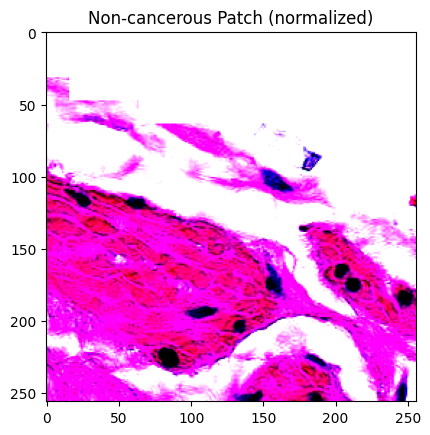

In [8]:
# with the datamodule setup, we can now inspect the data

# one batch of data is a tuple of patches, labels, and metadata
for patches, labels, metadata in mpdm.train_dataloader():

    # as an example one can visualize...
    sample_idx = 0

    # ... the first patch in the batch
    patch = patches[sample_idx]
    plt.imshow(patch.permute(1, 2, 0))

    # ... the label of the first patch in the batch
    label = labels[sample_idx]
    title = "Cancerous Patch" if label else "Non-cancerous Patch" + " (normalized)"
    plt.title(title)

    # ... and the metadata of the first patch in the batch
    metadata_sample = pd.DataFrame(metadata['patch_info']).iloc[sample_idx]
    display(metadata_sample.to_frame())

    # Only do this once as an example so break out of the loop 
    break


In [9]:
# It is also possible to check the number of batches
print(len(mpdm.train_dataloader()))

362


# Network

In [10]:
from src.architecture import get_cancer_indicator_net

# The cancer indicator network consists of an effnet backbone and a target head that predicts the probability of a patch being cancerous
cancer_indicator_net = get_cancer_indicator_net(
    effnet_kwargs=dict(
        pretrained=True,
    ),
    target_kwargs=dict(
        drop_rate=0.5,
        num_classes=2,
    ),
)
cancer_indicator_net

/home/patrick/.conda/envs/env-pcai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/patrick/.conda/envs/env-pcai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): EfficientnetBackbone(
    (backbone_features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
            

# Training

In [11]:
# For training, the CancerIndicatorLitModule wraps the network and the optimizer
litmodule = CancerIndicatorLitModule(
    net=cancer_indicator_net,
    optimizer=Adam,
    n_classes=2, # only predict cancerous / non-cancerous
    use_weights=True,
)

In [12]:
class MetricTracker(Callback):

  def __init__(self):
    self.outputs = []

  def on_validation_batch_end(self, trainer, module, outputs, *args):
    self.outputs.append(outputs)

# This tracker is used for the learning curve below
cb = MetricTracker()

trainer = Trainer(
    accelerator="cpu",
    max_epochs=max_epochs,
    num_sanity_val_steps=0,
    callbacks=[cb],
)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/patrick/.conda/envs/env-pcai/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(


In [13]:
def find_latest_version_checkpoint_path(logs_path='lightning_logs'):
    """Returns the path to the latest version of the checkpoint file in the given directory.
    """

    import os
    from glob import glob
    import pandas as pd

    paths = glob(
        os.path.join(logs_path, '**/*.ckpt'), 
        recursive=True,
    )

    if len(paths) == 0:
        print(f"No checkpoint files found in {logs_path}")
        return None

    return (
        pd.DataFrame(paths, columns=['filepath'])
        .assign(version=lambda x: x['filepath'].str.extract(r'version_(\d+)').astype(float))
        .sort_values('version')
        .dropna()
        .iloc[-1]
    ).filepath



In [15]:
if retrain:
    if use_latest_weights:
        # get newest checkpoint path from lightning_logs
        path = find_latest_version_checkpoint_path()
        print(f"Loading weights from {path}")
        trainer.fit(model=litmodule, datamodule=mpdm, ckpt_path=path)
    else:
        trainer.fit(model=litmodule, datamodule=mpdm)
else:
    litmodule.load_from_checkpoint(
        find_latest_version_checkpoint_path(),
        net=cancer_indicator_net,
    )

In [20]:
if retrain:
    # If training was performed, the learning curve can be shown
    losses = pd.Series([out['loss'] for out in cb.outputs], name='loss', dtype='float32')
    fig, ax = plt.subplots()

    ax.plot(
        losses,
        marker='x',
        color='tab:blue'
    )
    ax.set_xlabel('Step')
    ax.set_ylabel('Loss')

    # only whole numbers on x axis
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Predict

In [17]:
# For prediction, prepare the dataloader and litmodule
mpdm.setup('predict')
litmodule.eval()

Loaded predict_dataset: MaskedPatchDataset(15 image(s), 1000 patch(es) [500 pos, 500 neg])


CancerIndicatorLitModule(
  (net): Sequential(
    (0): EfficientnetBackbone(
      (backbone_features): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Sequential(
          (0): MBConv(
            (block): Sequential(
              (0): Conv2dNormActivation(
                (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
                (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): SiLU(inplace=True)
              )
              (1): SqueezeExcitation(
                (avgpool): AdaptiveAvgPool2d(output_size=1)
                (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
                (fc2): Conv2d(8, 32, kernel_size=(1, 1), s

In [18]:
# get the predictions and convert them to a pandas dataframe along with the provided metadata
predictions = CancerIndicatorLitModule.get_predictions_df(
    trainer.predict(model=litmodule, datamodule=mpdm)
)

/home/patrick/.conda/envs/env-pcai/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

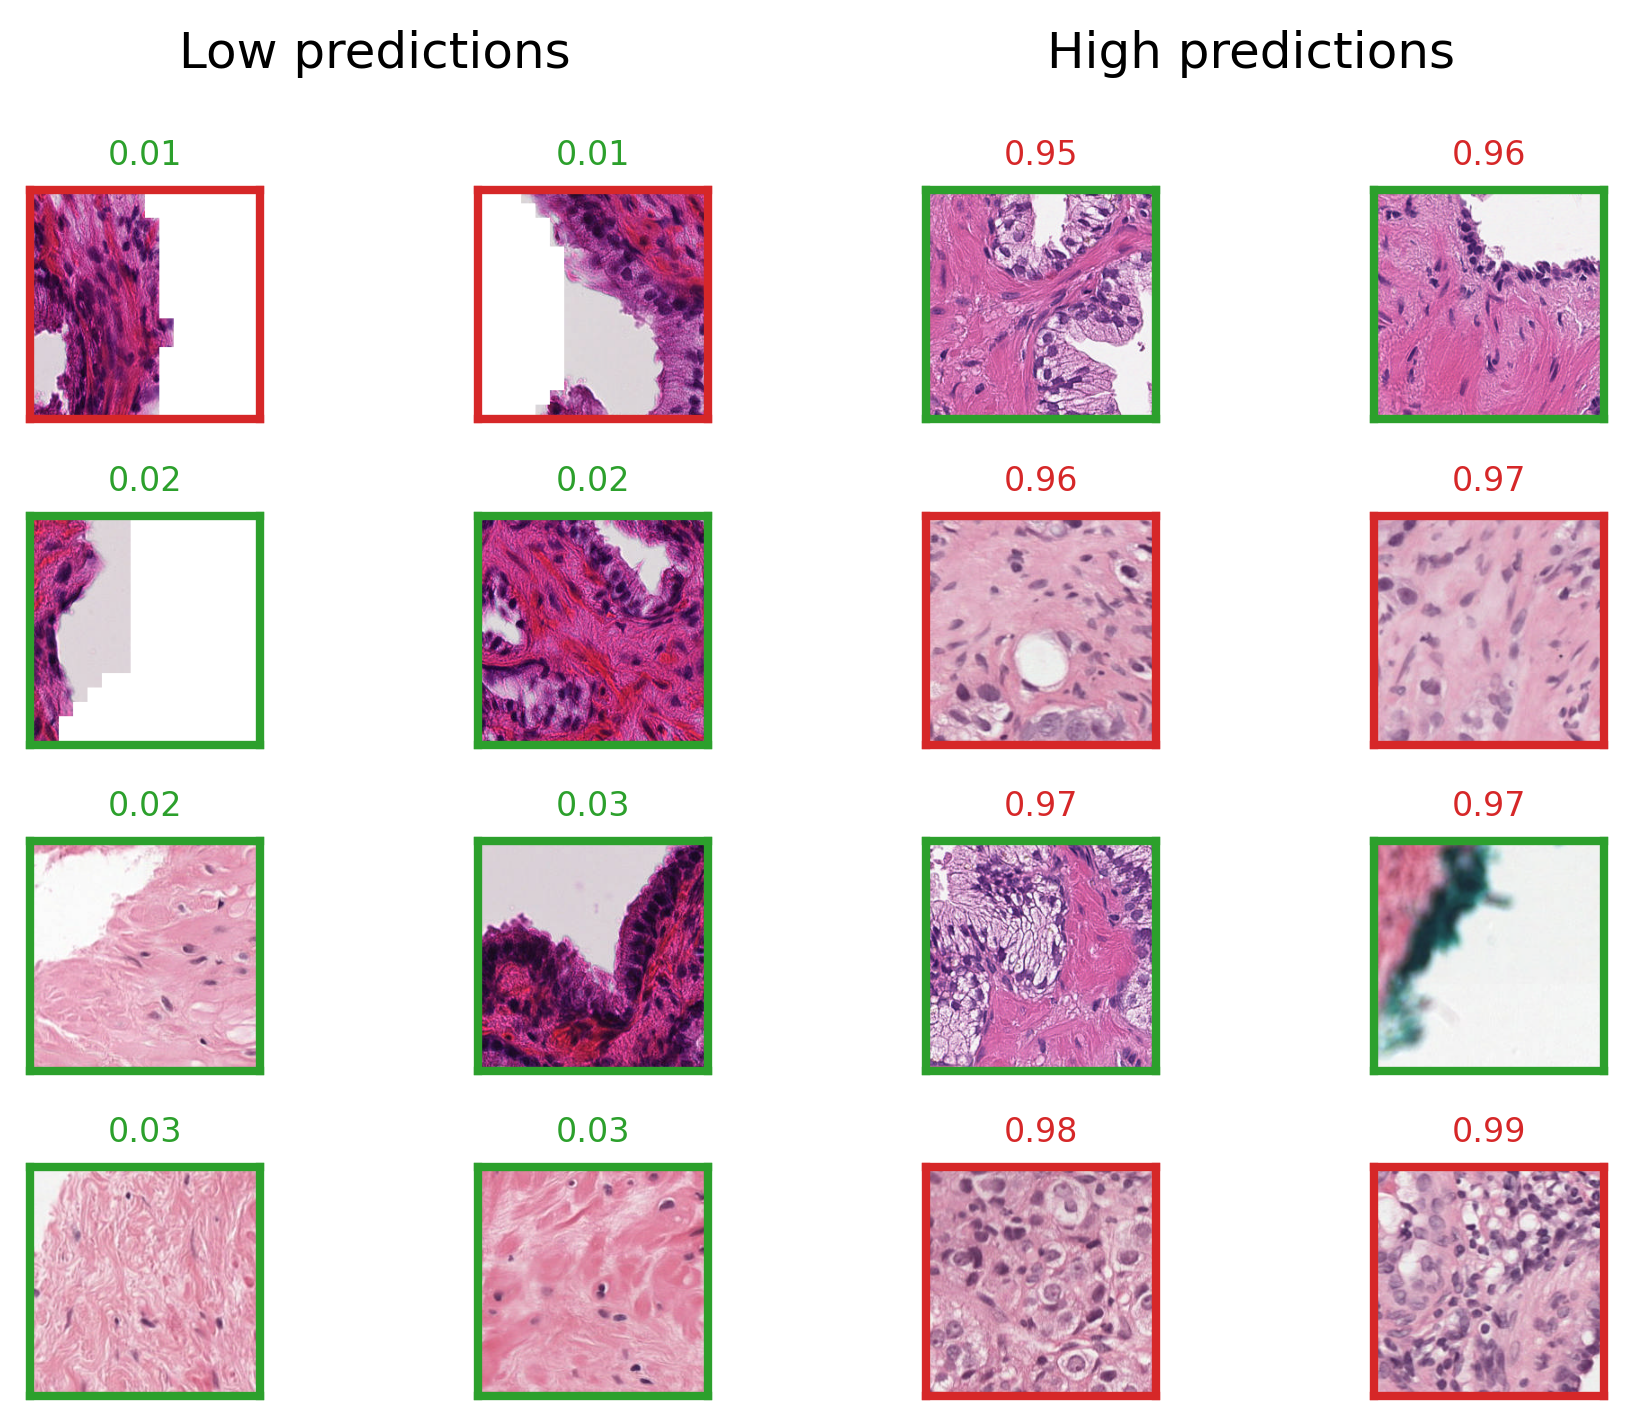

In [31]:
def extract_predictions(predictions, n, highest=True):
    """Extract the highest or lowest predictions from the predictions dataframe.
    """

    # only keep 5 patches per slide
    result = (
        predictions
        .groupby('filename', as_index=False)
        .sample(5, random_state=42)
        .sort_values('prediction', ascending=not highest)
        .head(n)
    )

    if highest:
        result = result.iloc[::-1]

    return result


# Finally, plot examples of the lowest and highest predictions indicated by the prediction color (green=low, red=high). 
# The border around each patch indicates a negative (green) or positive label (red)

nrows = 4
samples_per_group = 8
ncols= 4 # middle column is left empty
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, dpi=300)

for i, ax_col in enumerate(axs.T):

    for j, ax in enumerate(ax_col):

        if i < 2:
            is_high_predictions = False
            tmp_df = extract_predictions(predictions, samples_per_group, highest=False)
        else:
            is_high_predictions = True
            tmp_df = extract_predictions(predictions, samples_per_group, highest=True)

        tmp_pred = tmp_df.iloc[i%2::2].iloc[j]

        OpenslidePatchLoader(
            filepath=os.path.join(img_base_dir, tmp_pred.filename),
            patch_size=patch_size,
            channel_is_first_axis=False,
        ).plot_patch(tmp_pred.row, tmp_pred.col, ax=ax)    

        ax.set_title(f"{tmp_pred.prediction:.2f}", fontsize=8, color='tab:red' if is_high_predictions else 'tab:green')

        tmp_color = 'tab:red' if tmp_pred.label == 1 else 'tab:green'
        for spine in ax.spines.values():
            spine.set_edgecolor(tmp_color)
            spine.set_linewidth(2)
    
fig.suptitle("Low predictions" + " " * 30 + "High predictions")

plt.tight_layout()
plt.savefig('output/ci_prediction_examples.png', dpi=300, bbox_inches='tight')